# Quantum Nueral Network 






## Two Input Qunatum Binary Classifier

### Imports


*   *cirq*  for creating and optimizing quantum circuits and running them against quantum computers and simulators.
*   *pennylane* to handle hybrid machine learning optimization
*   *numpy* for multidimensional array data processing and manipulation 
*   *matplotlib* for visualizing model and data

In [0]:
pip install pennylane pennylane-cirq networkx==2.3

In [0]:
import numpy as np
import cirq
import matplotlib.pyplot as plt
import pennylane as qml
import math
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer, AdagradOptimizer

### Truly Random Number Generator
An important characteristic of qubits are their ability to represent a superposition of states (be a one and a zero at the same time). We can exploit this feature of qubits to generate truly random numbers by:


1.   Initialize a qubit
2.   Force the qubit into a superposition using Hadamard gate
3.   Measure the state of the qubit 
4.   Obtian a 0 or 1 with equal probability

The following truly random number generator will allow us to initialize our neural network with real random weights and baises at the start of training. Additionally, we can also generate random data points for this expirament.

Once we can generate a random 1 bit pattern, we must generalize this to n-bits so that we can generate a random bit pattern of any length to represent all reals. We also define a few auxiliary functions for future use.



In [0]:
def random_bit_generator(verbose=False):
  qubit = cirq.GridQubit(0,0)
  circuit = cirq.Circuit.from_ops(
      cirq.H(qubit),
      cirq.measure(qubit, key="m")
  )

  simulator = cirq.Simulator()
  result = simulator.run(circuit, repetitions=1)

  if verbose:
    print("Circuit:")
    print(circuit)

  random_bit = list(result.histogram(key='m'))[0]
  return random_bit
  

print("Generate random 1 bit:")
random_bit = random_bit_generator(True)
print(random_bit)


def random_n_bit_generator(n):
  rand_bit_pattern = ""
  for i in range(n):
    random_bit = random_bit_generator()
    rand_bit_pattern += str(random_bit)
  return bin(int(rand_bit_pattern, 2))


print("Generate random 32 bit pattern:")
random_bit_pattern = random_n_bit_generator(32)
print(random_bit_pattern)


def normalized_random_generator(n=32):
  random_bit_pattern = random_n_bit_generator(n)
  max_random_bit_pattern = int('1'*n, 2)
  return int(random_bit_pattern, 2)/max_random_bit_pattern


print("Normalized random number:")
print(normalized_random_generator())

The function Circuit.from_ops was used but is deprecated.
It will be removed in cirq v0.8.0.
use `cirq.Circuit(*ops)` instead.



Generate random 1 bit:
Circuit:
(0, 0): ───H───M('m')───
0
Generate random 32 bit pattern:
0b11000111000010000010001101101011
Normalized random number:
0.9949738432175884


### Implementing 2D Binary QNN



#### Generate 2D Non Convex Dataset

We will also show that we can train, optimize and test a binary classifier on a 2 dimensional data set. An example we can use for this is a QNN that can learn the boundries of a non convex function on a plane and determine if a given point is on one side of the curve. To do so we must generate a non convex function and random data points for the QNN to train/test on.  


Generate 5 non convex data points:
(array([[-0.92395851, -0.69754785],
       [-0.88603783, -0.13412038],
       [-0.33612648, -0.23999434],
       [-0.06169816,  0.12696609],
       [ 0.01687062, -0.55275551]]), array([0, 0, 1, 1, 0]))


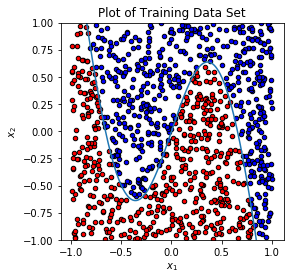

In [0]:
def function(s):
  return -2 * s + 1.5 * np.sin(np.pi * s)


def non_convex(num_samples):
  X_train, Y_train = [], []
  for i in range(num_samples):
    x = 2 * np.array([normalized_random_generator() for i in range(2)]) - 1
    y = 0
    if x[1] < function(x[0]): y = 0
    if x[1] > function(x[0]): y = 1
    X_train.append(x)
    Y_train.append(y)
  return np.array(X_train), np.array(Y_train)


print("Generate 5 non convex data points:")
print(non_convex(5))


def plot_data(x, y, fig=None, ax=None):
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

#Visualize training data on plot
X_train, Y_train = non_convex(1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(X_train, Y_train, fig=fig, ax=ax)
x = np.linspace(-1, 1, 1000)
plt.plot(x, function(x))
plt.ylim(-1, 1)
plt.title("Plot of Training Data Set")
plt.show()

#### Classification Label Representation

With our training data set ready, we are ready to build our two dimensional quantum neural network for binary classification. 

The first step in doing so will be to represent our classification labels as a quantum state vectors. We can then calculate the probability of these labels (states) for each input data using a density matrix representation. 

In [0]:
label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = [label_0, label_1]

def density_matrix(state):
    return state * np.conj(state).T

#### Implementing Network Neuron Cost Function

In order to learn model weights we must create neurons within the network that have an associated weight and bias components we can update during the training process. Additionally, we must be able to load the input data into a qubit and apply the learnt weights and biases to the neuron holding the information. We can do so using unitaries. 

##### Loading Data into Qubit

The following figure shows an example of how we can load our input data into a qubit by multiplying some initial state vector by a unitary containing our data. 
![Loading data into qubit](https://pennylane.ai/qml/_images/universal_bloch.png)

##### Applying Weights and Biases to Input

Once the data is loaded into the qubit, we can apply learning parameters to the data in the same manner using unitaries. Essentially, we apply two levels of matrix multiplication to the input (one for the weight and one for the bias). Applying this matrix multiplication over and over again (with different weights and biases) is akin to adding additional neurons in the same layer of the neural network. To implement multiple hidden layers in the network we use more than one qubit that are entangled together. The figure below shows the netowrk representation for multiple neurons in the same hidden layer and additional layers.
![Network Layer Representation](https://pennylane.ai/qml/_images/universal_dnn.png)

##### Neuron Activation

Once all the layers of the network have been applied to the input, the result is a point on the bloch sphere corresponding to the rotations caused by the unitaries applied to the input. We must be able to compute an output classification from this result. This can be done by calculating the measuring the closeness of the output state to the classification states (Blue = [1,0], Red = [0,1]).

In [0]:
dev = qml.device("default.qubit", wires=1)
# dev = qml.device("cirq.simulator", wires=1)
# dev = qml.device("qiskit.aer", wires=1)


@qml.qnode(dev)
def qcircuit(parameters, x=None, y=None):
    for param in parameters:
        qml.Rot(*x, wires=0)
        qml.Rot(*param, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(parameters, x, y, state_labels=None):
    # Compute prediction for each input in data batch
    loss = 0.0
    density_matrix_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(parameters, x=x[i], y=density_matrix_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)


def fidelity(state1, state2):
    return np.abs(np.dot(np.conj(state1), state2))

#### Defining Learning Functions

Next we must implement functions for training, testing, optimizing and analyzing our model over an input data set. 

In [0]:
def predicted_labels(states, state_labels=None):
    output_labels = [np.argmax([fidelity(s, label) for label in state_labels]) for s in states]
    return np.array(output_labels)

    
def test(parameters, x, y, state_labels=None):
    output_states = []
    density_matrix_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        expectation = qcircuit(params, x=x[i], y=density_matrix_labels[y[i]])
        output_states.append(dev._state)
    predicted = predicted_labels(output_states, state_labels)
    return predicted, output_states


def accuracy_score(y_true, y_prediction):
    score = y_true == y_prediction
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

#### Initializing Model and Experimental Data



##### Prepare Training and Test Data

In [0]:
# Generate training and test data
num_training = 200
num_test = 2000

Xdata, y_train = non_convex(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1))))

Xtest, y_test = non_convex(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1))))

##### Glorot Initialization
In order to correctly initialize our network with optimal weights for faster training, we implement Glorot initialization with truly random weights.

Glorot initialization generates optimal random weights for hidden nodes by taking into account network characteristics (number of input and output nodes). It initializes hidden node weights to a random number between two boundries. 

![Glorot Initilization](https://miro.medium.com/max/1753/1*uHKjF9HH65N4dTSWnECd8A.png)

In [0]:
num_layers = 8
def glorot(nin, nout, size=3):
  u_bound =  math.sqrt(6/(nin+nout))
  l_bound = -u_bound
  params = l_bound + (u_bound - l_bound) * np.array([[normalized_random_generator() for i in range(size)] for i in range(num_layers)]) 
  return params

##### Define Model Training Parameters

In [0]:
learning_rate = 0.6
epochs = 20
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

params = glorot(2, 2)
print("Glorot initialized weights")
print(params)

predicted_train, states_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, states_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params = opt.step(lambda v: cost(v, Xbatch, ybatch, state_labels), params)

    predicted_train, states_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, states_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))

Glorot initialized weights
[[-0.61063607  0.93862354  0.99325155]
 [ 0.51550143  1.11697549 -1.03834427]
 [-0.94710776  0.93250822  0.28403031]
 [-0.34760668 -0.08273524 -0.00608133]
 [ 0.60824256  0.14219474 -0.7781672 ]
 [-0.87284909  0.07154111 -0.82161679]
 [-0.86595411  0.61499773 -0.01359226]
 [ 0.30804431 -0.44209562 -0.45599644]]
Epoch:  0 | Cost: 0.206304 | Train accuracy: 0.720000 | Test Accuracy: 0.717000
Epoch:  1 | Loss: 0.151883 | Train accuracy: 0.775000 | Test accuracy: 0.733500
Epoch:  2 | Loss: 0.172301 | Train accuracy: 0.710000 | Test accuracy: 0.692000
Epoch:  3 | Loss: 0.117730 | Train accuracy: 0.835000 | Test accuracy: 0.821000
Epoch:  4 | Loss: 0.107696 | Train accuracy: 0.870000 | Test accuracy: 0.844500
Epoch:  5 | Loss: 0.095747 | Train accuracy: 0.885000 | Test accuracy: 0.880500
Epoch:  6 | Loss: 0.084463 | Train accuracy: 0.915000 | Test accuracy: 0.892000
Epoch:  7 | Loss: 0.077396 | Train accuracy: 0.935000 | Test accuracy: 0.925000
Epoch:  8 | Loss: 0.

#### Results

Cost: 0.065427 | Train accuracy 0.950000 | Test Accuracy : 0.944000


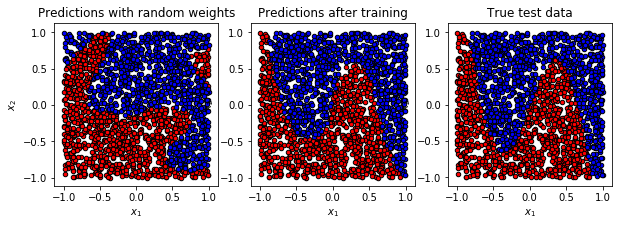

In [0]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.show()